In [2]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching
from imp import reload
reload(alpenglow.stitching)
from alpenglow.stitching import stitch, find_shift, apply_shift

In [3]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread

In [4]:
s3 = boto3.resource('s3')

bucket = s3.Bucket('alpenglowoptics')

ll = list(bucket.objects.all())

In [1]:
# for x in range(1,129):
#     for strip in [7,8,9]:
#         fname = "im_%06d_%06d.tif" % (strip, x)
#         af.download_s3('76AO/Strips/' + fname, '../data/' + fname)

NameError: name 'af' is not defined

In [5]:
images_7 = imread_collection("../data/im_000007_0*")
images_8 = imread_collection("../data/im_000008_0*")
images_9 = imread_collection("../data/im_000009_0*")


In [6]:
def stitch_zstack(images_1, images_2, current_stack):
    """
    
    """
    sub_images_1 = []
    sub_images_2 = []
    ps = []
    for x in range(10,100,10):
        p = int(np.percentile(np.arange(len(images_1)), x))
        sub_images_1_p = images_1[p]
        sub_images_2_p = images_2[p]
        sub_images_1.append(sub_images_1_p)
        sub_images_2.append(sub_images_2_p)
        ps.append(p)
    
    shift = []
    for x in range(len(sub_images_1)):
        shift.append(find_shift(sub_images_1[x], sub_images_2[x]))
    shift = np.array(shift)
    coef = []
    coef = np.polyfit(ps, shift[:,0], 1)
    
    shift_last = int(np.round(np.polyval(coef, len(images_1))))
    rows = images_1[0].shape[0]+images_2[0].shape[0]
    overlap = (images_2[0].shape[0]//2)+shift_last
    chop_index = int(rows - overlap)

    for z_level in range(len(images_1)):
        shift_zero = int(np.round(np.polyval(coef, z_level)))
        shift_one = int(np.round(np.mean(shift[:,1])))
        registered = apply_shift(images_1[z_level], images_2[z_level], [shift_zero, shift_one])
        tiff.imsave("mosaic_%06d_%06d.tif"%(current_stack, z_level+1), registered[:chop_index]) 
        

In [7]:
mosaic_8 = ImageCollection("mosaic_000008*", plugin="tifffile")

In [8]:
mosaic_8[0]

array([[29, 22, 27, ..., 22, 26, 26],
       [25, 34, 25, ..., 29, 24, 29],
       [26, 22, 30, ..., 26, 27, 30],
       ..., 
       [ 0,  0,  0, ..., 62, 66, 56],
       [ 0,  0,  0, ..., 54, 52, 65],
       [ 0,  0,  0, ..., 67, 69, 68]], dtype=int64)

In [22]:
stitch_zstack(mosaic_8, images_9, 9)

In [23]:
test_55 = imread("mosaic_000009_000055.tif")

In [24]:
test_55.shape

(1992, 23872)

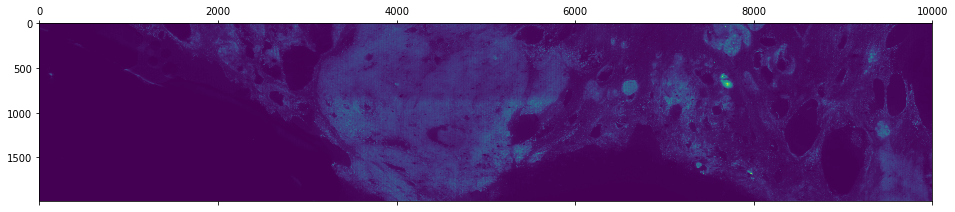

In [25]:
plt.matshow(test_55[:, 5000:15000])

In [19]:
pwd

'/home/nicholasreder/alpenglow/notebooks'

In [21]:
rm mosaic_000008*